In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
#import scipy.special as bessel
#from scipy.io import loadmat

import DRLPDE_nn
#import DRLPDE_param_solver
#import DRLPDE_functions.DefineDomain
#import DRLPDE_functions.EvaluateWalkers

import matplotlib.pyplot as plt
#import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300
#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = ['Computer Modern']
#plt.rcParams['font.size'] = 12

In [2]:
## Load Trained model

nn_depth = 60
nn_width = 4

x_dim = 2
output_dim = 2
is_unsteady = True
num_param = 2

input_dim = x_dim + is_unsteady + num_param

# X[:,0], X[:,1] space dimensions
# X[:,2] time dimension
# X[:,3] viscosity
# X[:,4] input speed

L_height = 0.5
Tmax = 1

Viscosity_min = 1e-2
Viscosity_max = 1e1

Inputspeed_min = 1
Inputspeed_max = 1e2

loadmodel = 'flowpastdisk_hyper'

imagefilename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

In [3]:
class IncompressibleNN(torch.nn.Module):
    
    ### Incompressible neural network
    ### curl operation built in
    
    def __init__(self, depth, width, x_dim, is_unsteady, num_param, **nn_param):
        super(IncompressibleNN, self).__init__()
        
        self.x_dim = x_dim
        self.input_dim = self.x_dim + is_unsteady + num_param
        
        self.dim_out = [1, 3][self.x_dim==3]
        
        modules = []
        modules.append(torch.nn.Linear(self.input_dim, depth))
        for i in range(width - 1):
            modules.append(torch.nn.Linear(depth, depth))
            modules.append(torch.nn.Tanh())
        modules.append(torch.nn.Linear(depth, self.dim_out))
                       
        self.sequential_model = torch.nn.Sequential(*modules)
    
    def curl(self, a, x):
        if self.x_dim == 2:
            
            dadx = torch.autograd.grad(a, x, grad_outputs = torch.ones_like(a), 
                                        create_graph = True, retain_graph = True, allow_unused=False)[0]


            u = torch.stack([dadx[:,1], -dadx[:,0]] , dim=1)
            
        elif self.x_dim == 3:
            e = torch.eye(self.x_dim, device=x.device)

            da0dx = torch.autograd.grad(a, x, grad_outputs=e[0,:].repeat(a.size(0), 1), 
                                        create_graph=True, retain_graph = True)[0]
            da1dx = torch.autograd.grad(a, x, grad_outputs=e[1,:].repeat(a.size(0), 1),
                                        create_graph=True, retain_graph = True)[0]
            da2dx = torch.autograd.grad(a, x, grad_outputs=e[2,:].repeat(a.size(0), 1),
                                        create_graph=True, retain_graph = True, allow_unused=True)[0]

            u = torch.stack([da2dx[:,1] - da1dx[:,2], da0dx[:,2] - da2dx[:,0], da1dx[:,0] - da0dx[:,1] ], dim=1)         
        return u
    
    def forward(self, x):
        a = self.sequential_model(x)
        u = self.curl(a, x)
            
        return u

In [4]:
nn_param = {'depth': nn_depth,
            'width': nn_width,
            'x_dim': x_dim,
            'is_unsteady': is_unsteady,
            'output_dim': output_dim,
            'num_param': num_param
            }
                
################ Preparing the model #################

#print("Initializing the model")

### Initialize the Model
model = IncompressibleNN(**nn_param)

model.load_state_dict(torch.load("savedmodels/" + loadmodel + ".pt"))

imagefilename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

In [16]:
### Making the video

### Choose time step
dt = 0.01
num_t = int( Tmax/dt )

### Choose your input speed and viscosity
Inputspeed = 5
Viscosity = 1

### Make domain

numplotpts_x = 4*64
numplotpts_y = 64
numplotpts = numplotpts_x*numplotpts_y

xg = torch.cartesian_prod(torch.linspace(0, 5*L_height, numplotpts_x), 
                           torch.linspace(-L_height, L_height, numplotpts_y))

domain = torch.cat( (xg, torch.zeros(xg.size(0), 1), torch.tensor([[Viscosity, Inputspeed]])*torch.ones((xg.size(0),2))),dim=1 )

xplot = xg[:,0].reshape(numplotpts_x, numplotpts_y).detach().numpy()
yplot = xg[:,1].reshape(numplotpts_x, numplotpts_y).detach().numpy()


In [9]:
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 5.0])
plt.tight_layout(pad=0.75)

for ii in range(0, num_t):

    domain.requires_grad=False
    domain[:,2] = ii*dt

    Trained_Vel = model(domain.requires_grad_(True)).reshape(numplotpts_x, numplotpts_y, 2).detach().numpy()

    quiver = ax.quiver([xplot,yplot], Trained_Vel, pivot='mid')

torch.Size([1, 2])

torch.Size([16384])

torch.Size([16384, 2])

(256, 64)

(256, 64)

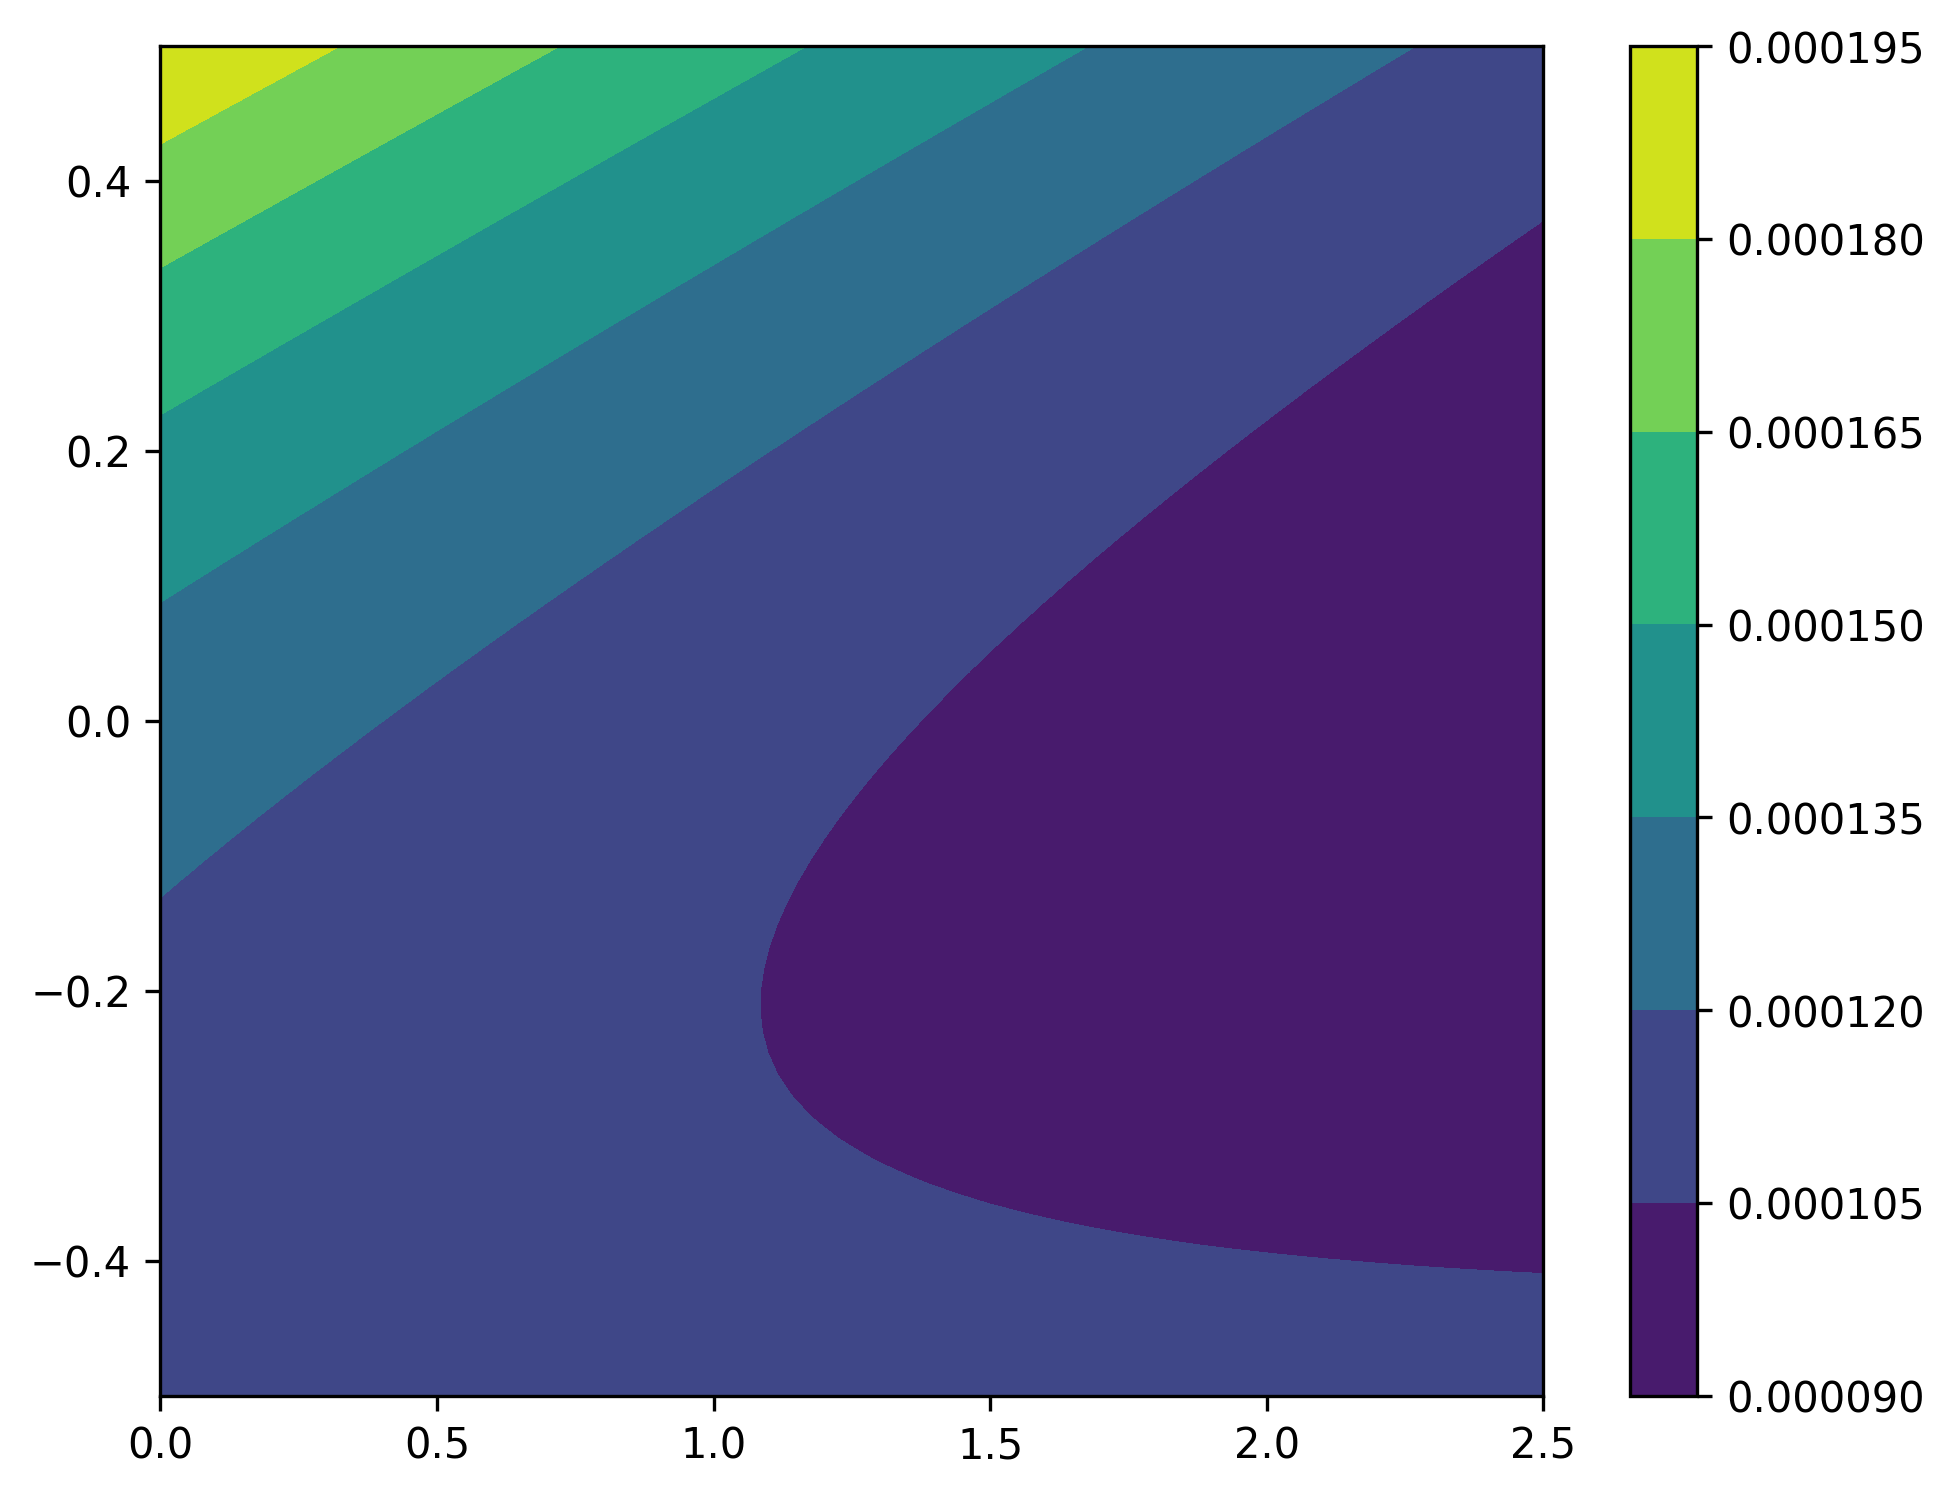

In [26]:
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 5.0])
plt.tight_layout(pad=0.75)

domain.requires_grad=False
domain[:,2] = 0.5

Trained_Vel = model(domain.requires_grad_(True)).reshape(numplotpts_x, numplotpts_y, 2).detach().numpy()

contour = ax.contourf(xplot, yplot, Trained_Vel[:,:,0])
plt.colorbar(contour)

#quiver = ax.quiver(xplot,yplot, Trained_Vel[:,:,0], Trained_Vel[:,:,1], pivot='mid')